<a href="https://colab.research.google.com/github/siva-sankar-a/eva_final_project/blob/master/EVA_S15_Part1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!rm -rf DenseDepth
!git clone https://github.com/ialhashim/DenseDepth.git

Cloning into 'DenseDepth'...
remote: Enumerating objects: 235, done.
remote: Total 235 (delta 0), reused 0 (delta 0), pack-reused 235
Receiving objects: 100% (235/235), 11.80 MiB | 6.05 MiB/s, done.
Resolving deltas: 100% (115/115), done.


In [2]:
!wget https://s3-eu-west-1.amazonaws.com/densedepth/nyu.h5 -O ./DenseDepth/nyu.h5

--2020-05-10 17:36:32--  https://s3-eu-west-1.amazonaws.com/densedepth/nyu.h5
Resolving s3-eu-west-1.amazonaws.com (s3-eu-west-1.amazonaws.com)... 52.218.84.234
Connecting to s3-eu-west-1.amazonaws.com (s3-eu-west-1.amazonaws.com)|52.218.84.234|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 172897376 (165M) [application/h5]
Saving to: ‘./DenseDepth/nyu.h5’

./DenseDepth/nyu.h5 100%[===================>] 164.89M  11.5MB/s    in 16s     

2020-05-10 17:36:49 (10.2 MB/s) - ‘./DenseDepth/nyu.h5’ saved [172897376/172897376]



In [0]:
%load_ext autoreload
%autoreload 2

In [0]:
import os
import glob
import argparse
import matplotlib

import numpy as np

# Keras / TensorFlow
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '5'
from keras.models import load_model
from DenseDepth.layers import BilinearUpSampling2D
from DenseDepth.utils import predict, load_images, display_images
from matplotlib import pyplot as plt

In [13]:
model = 'DenseDepth/nyu.h5'

# Custom object needed for inference and training
custom_objects = {'BilinearUpSampling2D': BilinearUpSampling2D, 'depth_loss_function': None}

print('Loading model...')

# Load model into GPU / CPU
model = load_model(model, custom_objects=custom_objects, compile=False)

print('\nModel loaded ({0}).'.format(model))

Loading model...

Model loaded (<keras.engine.training.Model object at 0x7f0419919dd8>).


In [0]:
root_dir = '/content/drive/My Drive/eva_final_data'

In [0]:
fg_bg_folder = 'fg_bg'

In [0]:
fg_bg_folder_path = os.path.join(root_dir, fg_bg_folder)

In [0]:
paths = [fg_bg_folder_path + '/img_00003800.jpg']

In [50]:
# Input images
inputs = load_images(paths)
print('\nLoaded ({0}) images of size {1}.'.format(inputs.shape[0], inputs.shape[1:]))


Loaded (1) images of size (224, 224, 3).


In [0]:
# Compute results
outputs = predict(model, inputs, minDepth=1, maxDepth=500)

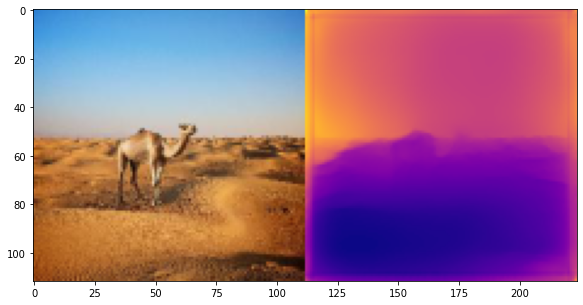

In [52]:
# Display results
viz = display_images(outputs.copy(), inputs.copy())
plt.figure(figsize=(10,5))
plt.imshow(viz)
plt.savefig('test.png')
plt.show()